1.首先计算重心，计算偏移量；<br> 
2.使用之前字体分割模型计算最小外边距，计算字面积差给分； <br> 
3.然后得出字符边界，提取出字符区域，然后resize相同，计算模版匹配相似度；<br>
4.分析凸包的Hausdorff 距离（豪斯多夫距离），是一种度量两个形状（点集）之间相似性的指标 ，Jaccard 相似度 来衡量形状相似度和凸包的形状特征<br> 

In [1]:
import cv2

print(cv2.__version__)

4.5.5


In [ ]:
import c

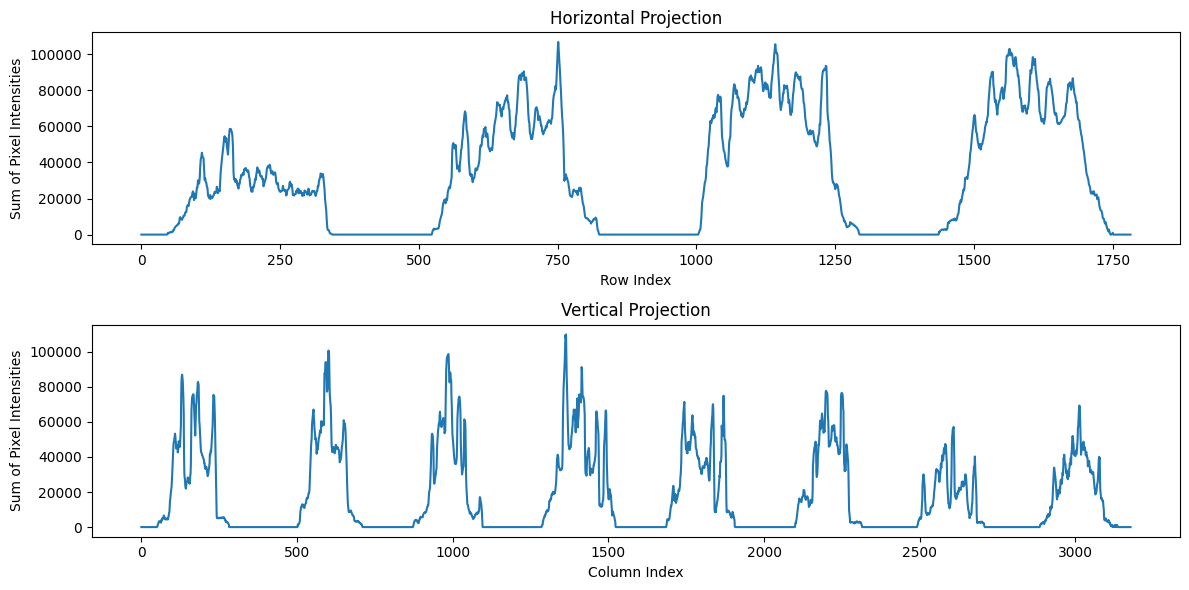

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_path = "/home/yly/workspace/text_score/image/test1_c(1).jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply binary thresholding
_, binary = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)

# Horizontal projection
horizontal_projection = np.sum(binary, axis=1)

# Vertical projection
vertical_projection = np.sum(binary, axis=0)

# Plot horizontal and vertical projections
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(horizontal_projection)
plt.title("Horizontal Projection")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Intensities")

plt.subplot(2, 1, 2)
plt.plot(vertical_projection)
plt.title("Vertical Projection")
plt.xlabel("Column Index")
plt.ylabel("Sum of Pixel Intensities")

plt.tight_layout()
plt.show()


In [10]:
# 横向投影（行）
threshold_row = np.mean(horizontal_projection) + np.std(horizontal_projection)
binary_row = (horizontal_projection > 10000).astype(int)

# 统计连续的 1 区块数量（行数）
from itertools import groupby
row_regions = [list(g) for k, g in groupby(binary_row) if k == 1]
num_rows = len(row_regions)

# 同理，纵向（列）
threshold_col = np.mean(vertical_projection) + np.std(vertical_projection)
binary_col = (vertical_projection > 5000).astype(int)
col_regions = [list(g) for k, g in groupby(binary_col) if k == 1]
num_cols = len(col_regions)

num_rows, num_cols

(4, 13)

In [7]:
from scipy.signal import find_peaks, peak_widths

# 自适应高度阈值（均值 + 标准差）
adaptive_height_row = np.mean(horizontal_projection) + np.std(horizontal_projection)
adaptive_height_col = np.mean(vertical_projection) + np.std(vertical_projection)

# 找所有高度较高的峰（不设 distance）
row_peaks, _ = find_peaks(horizontal_projection, height=10000)
col_peaks, _ = find_peaks(vertical_projection, height=10000)

# 计算峰宽度（可用于进一步筛选）
row_widths = peak_widths(horizontal_projection, row_peaks, rel_height=0.5)[0]
col_widths = peak_widths(vertical_projection, col_peaks, rel_height=0.5)[0]

# 自动去除宽度太小的伪峰（如宽度<10的跳过）
filtered_row_peaks = [p for p, w in zip(row_peaks, row_widths) if w > 10]
filtered_col_peaks = [p for p, w in zip(col_peaks, col_widths) if w > 10]

# 得到最终的行列数
num_rows = len(filtered_row_peaks)
num_cols = len(filtered_col_peaks)

num_rows, num_cols


(20, 21)

In [ ]:
from scipy.signal import find_peaks
# 自适应最小间距：根据投影长度估算
adaptive_distance_row = len(horizontal_projection) // 10
adaptive_distance_col = len(vertical_projection) // 10
# 归一化到 [0, 1]
norm_horizontal = (horizontal_projection - np.min(horizontal_projection)) / (np.max(horizontal_projection) - np.min(horizontal_projection))
norm_vertical = (vertical_projection - np.min(vertical_projection)) / (np.max(vertical_projection) - np.min(vertical_projection))

# 自适应选择阈值：如 0.4 作为基准
row_peaks, _ = find_peaks(norm_horizontal, height=0.4, distance=adaptive_distance_row)
col_peaks, _ = find_peaks(norm_vertical, height=0.4, distance=adaptive_distance_col)
num_rows = len(row_peaks)
num_cols = len(col_peaks)

num_rows, num_cols


(5, 8)

In [4]:
from scipy.signal import find_peaks
# Detect peaks (rows of text)
row_peaks, _ = find_peaks(horizontal_projection, height=20000, distance=200)
# Detect peaks (columns of text)
col_peaks, _ = find_peaks(vertical_projection, height=20000, distance=200)

num_rows = len(row_peaks)
num_cols = len(col_peaks)

num_rows, num_cols

(4, 8)

In [1]:
import torch
print(torch.__version__)

2.4.1


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
img = cv2.imread(r'/home/yly/workspace/text_score/image/test1_c(1).jpg')
print(img.shape)

(1783, 3178, 3)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
img = cv2.imread('/home/yly/workspace/text_score/testimg/sm.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 边缘检测
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# 霍夫直线检测
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

# 分别收集横线和竖线
h_lines = []
v_lines = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    if abs(y1 - y2) < abs(x1 - x2):  # 横线
        h_lines.append((y1 + y2) // 2)
    else:  # 竖线
        v_lines.append((x1 + x2) // 2)

# 去重，并排序
h_lines = sorted(list(set(h_lines)))
v_lines = sorted(list(set(v_lines)))

# 可视化看看检测到的横纵线数量
print(f"检测到横线 {len(h_lines)} 条，竖线 {len(v_lines)} 条")

# 根据线交点提取小格子
cells = []
for i in range(len(v_lines)-1):
    for j in range(len(h_lines)-1):
        x1, x2 = v_lines[i], v_lines[i+1]
        y1, y2 = h_lines[j], h_lines[j+1]
        cell = img[y1:y2, x1:x2]
        cells.append(cell)

# 展示部分裁剪结果
for idx, cell in enumerate(cells[:10]):
    plt.subplot(2,5,idx+1)
    plt.imshow(cv2.cvtColor(cell, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


In [8]:
import numpy as np
scaled_similarity=92
mapped_similarity = 100 * (1 - np.exp(-scaled_similarity / 20)) 
print(mapped_similarity)
mapped_similarity = 100 * np.log1p(scaled_similarity) / np.log1p(100)
print(mapped_similarity)
mapped_similarity = min(100, scaled_similarity ** 2 / 88)
print(mapped_similarity)


98.99481642553664
98.21194217167519
96.18181818181819


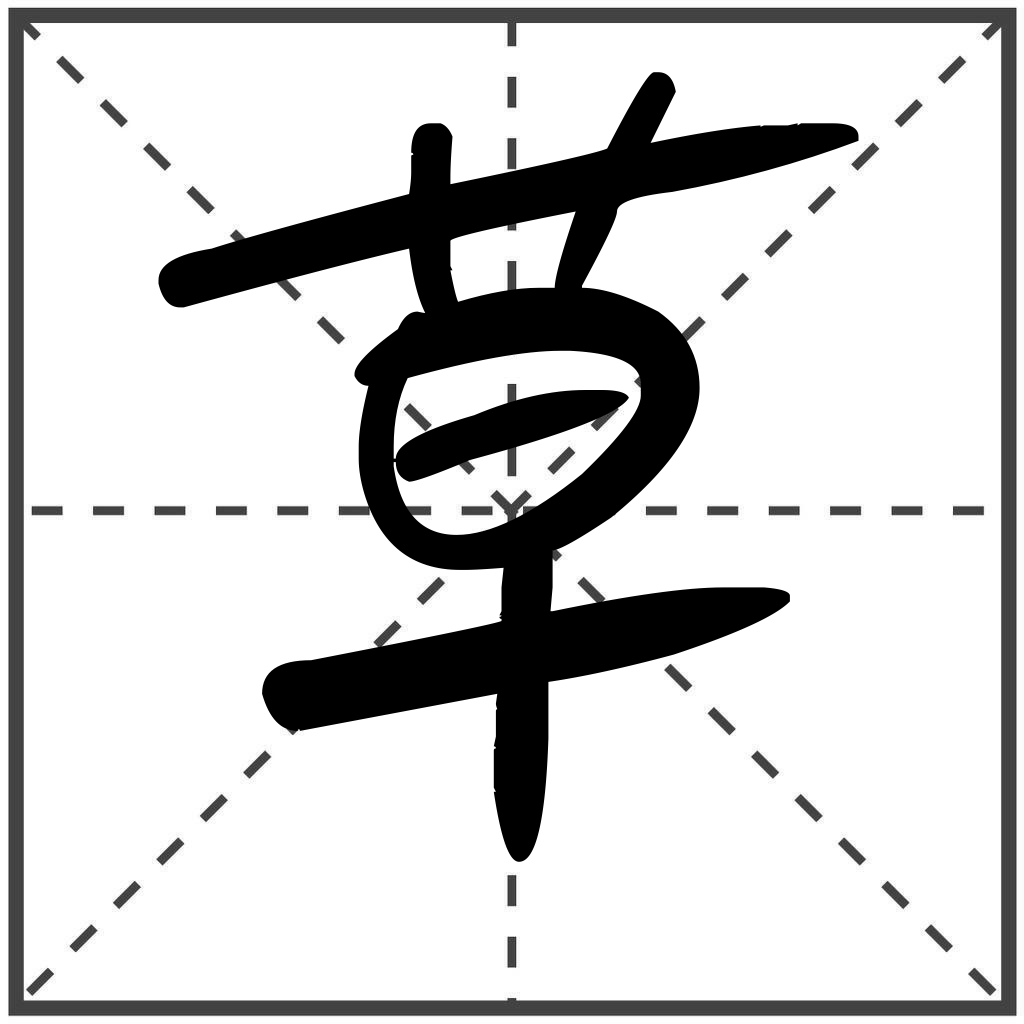

In [12]:
import cv2
image_path="/mnt/ylyu/text_data/草/font1.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
from PIL import Image
x=Image.fromarray(img)
x

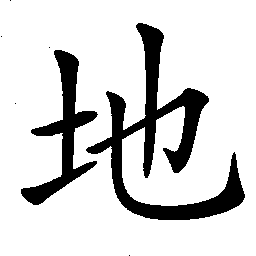

In [ ]:
import cv2
import numpy as np
import cv2
import numpy as np

# 读取图片
image_path = "/home/ylyu/workspace/text_score/corrected_img.png"
image = cv2.imread(image_path)

# 将BGR格式转换为RGB格式
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 计算通道之间的差值
# 对于红色和粉色，通常红色通道会比较大，而绿色和蓝色的值较小
# 你可以通过调整这两个差值来检测不同的颜色

# 计算红色通道和绿色、蓝色通道的差值
red_green_diff = np.abs(image_rgb[:, :, 0] - image_rgb[:, :, 1])
red_blue_diff = np.abs(image_rgb[:, :, 0] - image_rgb[:, :, 2])

# 创建条件，识别出符合红色、粉色等的区域
# 你可以根据实际情况调整阈值
threshold = 50
#mask = (red_green_diff > threshold) & (red_blue_diff > threshold)
#mask = np.any(image_rgb > 50, axis=-1)
mask = image_rgb[:, :, 0] > 50  # 0代表红色通道

# 将符合条件的区域替换为白色
image_rgb[mask] = [255, 255, 255]

# 将RGB格式转换回BGR格式
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
corrected_img_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        
_, binary_img = cv2.threshold(corrected_img_gray, 100, 255, cv2.THRESH_BINARY)
# 保存或显示修改后的图片
cv2.imwrite("modified_image.png", image_bgr)
from PIL import Image
x=Image.fromarray(binary_img)
x



In [1]:
import cv2
import numpy as np
import os
from PIL import Image

# 图像预处理：二值化、反转、去噪、去背景
def preprocess_image(image_path, invert=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    if invert:
        binary_img = cv2.bitwise_not(binary_img)
    
    binary_img = cv2.medianBlur(binary_img, 5)
    return binary_img

def remove_background(image):
    _, binary_img = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY)
    image[binary_img == 255] = 0
    return image


# 图像缩放：保持长宽比
def resize_image(image, target_size):
    x, y, w, h = cv2.boundingRect(image)
    max_side = max(w, h)
    square_img = cv2.resize(image, (max_side, max_side))
    resized_img = cv2.resize(square_img, (target_size, target_size))
    return resized_img

# 全局特征计算

# 计算最大覆盖率
def max_coverage_rate(src_img, target_img):
    src_area = np.sum(src_img == 255)
    target_area = np.sum(target_img == 255)
    overlap_area = np.sum(np.bitwise_and(src_img, target_img) == 255)
    coverage_rate = (overlap_area) / float(src_area)
    return coverage_rate

# 计算X轴和Y轴的直方图
def calculate_histogram(image):
    hist_x = np.sum(image, axis=0)  # X轴
    hist_y = np.sum(image, axis=1)  # Y轴
    return hist_x, hist_y

# 计算重心
def calculate_center_of_gravity(image):
    moments = cv2.moments(image)
    if moments["m00"] != 0:
        cX = int(moments["m10"] / moments["m00"])
        cY = int(moments["m01"] / moments["m00"])
    else:
        cX, cY = 0, 0

# 计算凸包
def convex_hull(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull = cv2.convexHull(contours[0])  # 假设只有一个轮廓
    

    return hull

# 字符图像平移：计算图像偏移
def shift_image(image, dx, dy):
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted_image

def find_max_text_bbox(image):
    # 确保输入为二值图像
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

     # 形态学优化（保持结构完整性）
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    processed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 寻找轮廓（假设文字为白色255）
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
    
    if not contours:
        return None  # 无文字区域
    
    # 找到最大面积的轮廓
    print(len(contours))
    max_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(max_contour)  # 假设只有一个轮廓
    # 计算外接矩形
    x, y, w, h = cv2.boundingRect(max_contour)
    return (x, y, x+w, y+h),hull  # 返回左上和右下坐标
def normalize_convex_hull(hull, target_size=(50, 50)):
    """ 归一化凸包到相同尺寸 """
    x, y, w, h = cv2.boundingRect(hull)  # 计算凸包的外接矩形
    scale_x = target_size[0] / w  # 计算缩放因子（x 方向）
    scale_y = target_size[1] / h  # 计算缩放因子（y 方向）
    
    # 归一化凸包点，使其映射到 target_size 内
    normalized_hull = np.array([[(int((pt[0][0] - x) * scale_x), int((pt[0][1] - y) * scale_y))] for pt in hull], dtype=np.int32)
    
    return normalized_hull

In [2]:
source_image_path = r'/home/ylyu/workspace/text_score/data/zhang/demo1.png'  # 替换为实际路径
target_image_path = r'/home/ylyu/workspace/text_score/data/zhang/basic.png'  # 替换为实际路径
img1_path=r'/home/ylyu/workspace/text_score/data/ni/demo1.jpg'
img2_path=r'/home/ylyu/workspace/text_score/data/zhang/demo2.jpg'
img3_path=r'/home/ylyu/workspace/text_score/data/zhang/demo3.jpg'
img4_path=r"/home/ylyu/workspace/text_score/data/qi/demo1.png"
src_img = preprocess_image(source_image_path, invert=True)
target_img = preprocess_image(target_image_path, invert=True)
img1=preprocess_image(img1_path, invert=True)
img2=preprocess_image(img2_path, invert=True)
img3=preprocess_image(img3_path, invert=True)
img4=preprocess_image(img4_path,invert=True)

In [3]:
# 字符裁剪（提取单个字符）
    # 图像缩放：保持长宽比
src_char_img_resized = resize_image(src_img, 128)
target_char_img_resized = resize_image(target_img , 128)
img1_resized=resize_image(img1,128)
img2_resized=resize_image(img2,128)
img3_resized=resize_image(img3,128)
img4_resized=resize_image(img4,128)

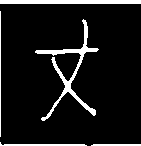

In [4]:
image = Image.fromarray(src_img)
image

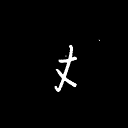

In [5]:
image = Image.fromarray(img2_resized)
image

2


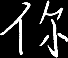

In [7]:
bbox,hull = find_max_text_bbox(img1_resized)

# 可视化结果
if bbox:
    result = cv2.cvtColor(img1_resized, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(result, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
    #cv2.imshow('Result', result)
    #cv2.waitKey(0)
x_min, y_min, x_max, y_max = bbox
    
    # 1. 裁剪区域
cropped_region = img1_resized[y_min:y_max, x_min:x_max]
image = Image.fromarray(cropped_region)
image

In [6]:
bbox

(24, 37, 92, 95)

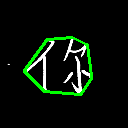

In [37]:
result1 = cv2.cvtColor(img1_resized, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result1, [hull], -1, (0,255,0), 2)
image1 = Image.fromarray(result1)
image1

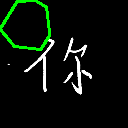

In [38]:
hull1_norm = normalize_convex_hull(hull)
result1 = cv2.cvtColor(img1_resized, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result1, [hull1_norm], -1, (0,255,0), 2)
image1 = Image.fromarray(result1)
image1

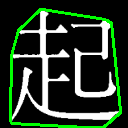

In [32]:
result1 = cv2.cvtColor(img4_resized, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result1, [hull], -1, (0,255,0), 2)
image1 = Image.fromarray(result1)
image1

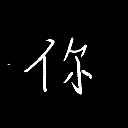

In [38]:
image1 = Image.fromarray(img1_resized)
image1

In [9]:
coverage_rate = max_coverage_rate(src_char_img_resized, target_char_img_resized)
coverage_rate

0.2909090909090909

In [12]:
hist_x_src, hist_y_src = calculate_histogram(src_char_img_resized)
hist_x_target, hist_y_target = calculate_histogram(target_char_img_resized)
#print(hist_x_src,hist_y_src)
#print(hist_x_target,hist_y_target)

In [13]:
np.sum(np.abs(hist_x_src - hist_x_target)) + np.sum(np.abs(hist_y_src - hist_y_target))

/tmp/ipykernel_13628/3638209491.py:1: RuntimeWarning: overflow encountered in scalar add
  np.sum(np.abs(hist_x_src - hist_x_target)) + np.sum(np.abs(hist_y_src - hist_y_target))


18446744073709196186

In [4]:
cX_src, cY_src = calculate_center_of_gravity(src_char_img_resized)
cX_target, cY_target = calculate_center_of_gravity(target_char_img_resized)
# 计算平移量（例如，通过计算重心的偏移来确定）
dx = cX_target - cX_src
dy = cY_target - cY_src
print(dx,dy)

11 9


In [5]:
print(cX_src,cY_src,cX_target,cY_target)

58 53 69 62


In [15]:
shifted_img = shift_image(src_char_img_resized, dx, dy)
coverage_rate1 = max_coverage_rate(shifted_img, target_char_img_resized)
coverage_rate1

0.12038303693570451

In [5]:
hull_src = convex_hull(src_char_img_resized)
result = cv2.cvtColor(src_char_img_resized, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result, [hull_src], -1, (0,255,0), 2)
hull_target = convex_hull(target_char_img_resized)
#print(hull_src)

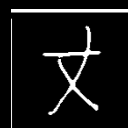

In [21]:
image2 = Image.fromarray(shifted_img)
image2

In [ ]:


bbox = find_max_text_bbox(src_char_img_resized)

# 可视化结果
if bbox:
    result = cv2.cvtColor(src_char_img_resized, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(result, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
    #cv2.imshow('Result', result)
    #cv2.waitKey(0)

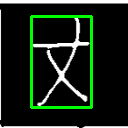

In [9]:
from PIL import Image
x=Image.fromarray(result)
x

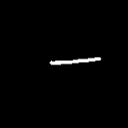

In [6]:
from tools import *
source_image_path = r'/home/ylyu/workspace/text_score/data/mu/mu_tar/heng.png'  # 替换为实际路径
target_image_path = r'/home/ylyu/workspace/text_score/data/shu/image.png'  # 替换为实际路径
src_img = preprocess_image(source_image_path,invert=True)
target_img = preprocess_image(target_image_path)
src_char_img_resized = resize_image(src_img, 128)
target_char_img_resized = resize_image(target_img , 128)
x=Image.fromarray(src_img)
y=Image.fromarray(src_char_img_resized)
y

In [6]:
contours, _ = cv2.findContours(target_char_img_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大面积的轮廓
#print(len(contours))
max_contour = max(contours, key=cv2.contourArea)
hull = cv2.convexHull(max_contour)  # 假设只有一个轮廓
# 计算外接矩形
x, y, w, h = cv2.boundingRect(max_contour)
print(x, y, w, h)
rect = cv2.minAreaRect(max_contour)
(x,y), (w,h), angle = rect
print(x, y, w, h,angle)
print(angle)

41 14 23 102
52.0 64.5 101.0 22.0 90.0
90.0


In [6]:
bbox_s,hull_s = find_max_text_bbox(src_char_img_resized)
bbox_t,hull_t = find_max_text_bbox(target_char_img_resized)

#裁剪出字符区域，以及字符面积
cropped_s, area_s = crop_and_resize(src_char_img_resized, bbox_s)
cropped_t, area_t = crop_and_resize(target_char_img_resized, bbox_t)
print(area_s,area_t)

7569 13209


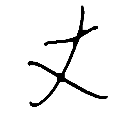

In [11]:
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(src_char_img_resized, cv2.MORPH_OPEN, kernel)
from PIL import Image
x=Image.fromarray(opening)
y=Image.fromarray(src_char_img_resized)
x

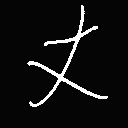

In [10]:
img = cv2.GaussianBlur(src_char_img_resized, (3, 3), 3)
th = cv2.adaptiveThreshold(src_char_img_resized, 250, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 35, 11)
th = cv2.bitwise_not(th)
kernel = np.array([[0, 1, 1],
                        [0, 1, 0],
                        [1, 1, 0]], dtype='uint8')
th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)
from PIL import Image
x=Image.fromarray(th)
y=Image.fromarray(src_char_img_resized)
x

图片1的关键点数目：22
图片2的关键点数目：50


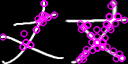

In [34]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(cropped_s,None)   #des是描述子
#sift.detectAndComputer(gray， None)计算出图像的关键点和sift特征向量   参数说明：gray表示输入的图片
#des1表示sift特征向量，128维
print("图片1的关键点数目："+str(len(kp1)))
#print(des1.shape)
kp2, des2 = sift.detectAndCompute(cropped_t,None)  #des是描述子
print("图片2的关键点数目："+str(len(kp2)))
img3 = cv2.drawKeypoints(cropped_s,kp1,cropped_s,color=(255,0,255)) #画出特征点，并显示为红色圆圈
#img3 = cv2.drawKeypoints(gray, kp, img) 在图中画出关键点   参数说明：gray表示输入图片, kp表示关键点，img表示输出的图片
#print(img3.size)
img4 = cv2.drawKeypoints(cropped_t,kp2,cropped_t,color=(255,0,255)) #画出特征点，并显示为红色圆圈

hmerge = np.hstack((img3, img4)) #水平拼接
y=Image.fromarray(hmerge)
y

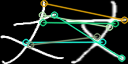

In [36]:
# BFMatcher解决匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
#print(matches)
#print(len(matches))
# 调整ratio
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
#img5 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)
img5 = cv2.drawMatchesKnn(cropped_s,kp1,cropped_t,kp2,good,None,flags=2)
y=Image.fromarray(img5)
y

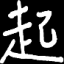

In [7]:
from PIL import Image
x=Image.fromarray(cropped_s)
y=Image.fromarray(cropped_t)
x

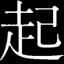

In [4]:
y

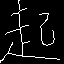

In [8]:
thin_image1 = cv2.ximgproc.thinning(cropped_s)  # OpenCV 实现 ZS 细化
thin_image2 = cv2.ximgproc.thinning(cropped_t)
x=Image.fromarray(thin_image1)
y=Image.fromarray(thin_image2)
x

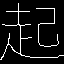

In [9]:
y

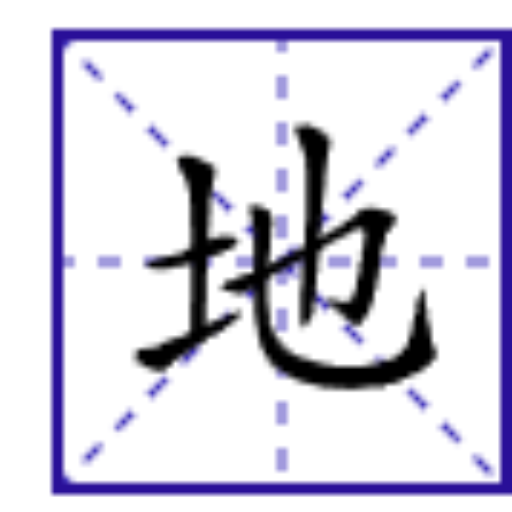

In [34]:
import cv2
img=cv2.imread("/home/ylyu/workspace/text_score/data/di/demo1.png")
img=cv2.resize(img,(512,512))
x=Image.fromarray(img)
x

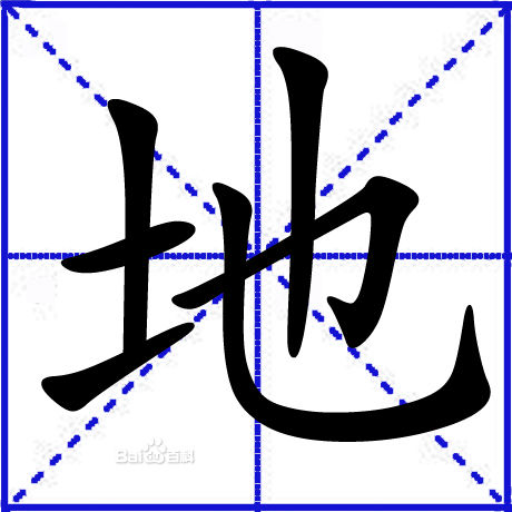

In [35]:
img=cv2.imread("/home/ylyu/workspace/text_score/data/di/tar.png")
img=cv2.resize(img,(512,512))
x=Image.fromarray(img)
x

In [31]:
from tools.correct import *
image_path = r'/home/ylyu/workspace/text_score/data/di/tar.png'
corrected_img=correct(image_path)
corrected_img_gray = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2GRAY)
#cv2.imwrite("corrected_img_gray1.png",corrected_img_gray)
_, binary_img = cv2.threshold(corrected_img_gray, 50, 255, cv2.THRESH_BINARY)


/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/1771969564.py:48: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from curren

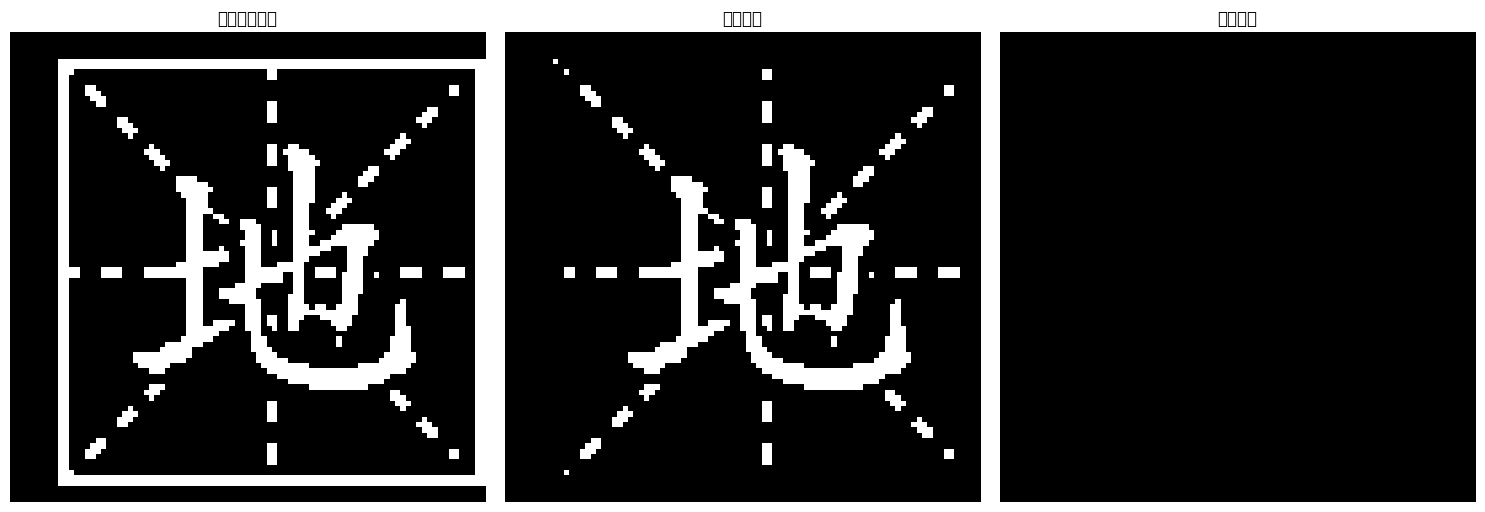

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
image_path = "/home/ylyu/workspace/text_score/data/di/demo1.png"  # 替换为你的图片路径
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# **1️⃣ 自适应二值化**
binary_img = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

# **2️⃣ 先用高斯模糊去噪**
blurred_img = cv2.GaussianBlur(binary_img, (3, 3), 0)
_, binary_img = cv2.threshold(blurred_img, 127, 255, cv2.THRESH_BINARY)

# **3️⃣ 检测水平 & 垂直网格线**
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel)
vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel)

grid_lines = cv2.add(horizontal_lines, vertical_lines)  # 合并网格线

# **4️⃣ 仅去除网格**
cleaned_img = cv2.subtract(binary_img, grid_lines)

# **5️⃣ 图像修复（可选）**
mask = cv2.bitwise_not(cleaned_img)
restored_img = cv2.inpaint(binary_img, mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

# **显示结果**
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(binary_img, cmap='gray')
axes[0].set_title("原始二值图像")
axes[0].axis("off")

axes[1].imshow(cleaned_img, cmap='gray')
axes[1].set_title("去除网格")
axes[1].axis("off")

axes[2].imshow(restored_img, cmap='gray')
axes[2].set_title("修复笔画")
axes[2].axis("off")

plt.tight_layout()
plt.show()




原始边框像素值：
 [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


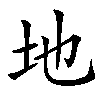

In [32]:
from PIL import Image
x=Image.fromarray(binary_img)
print("原始边框像素值：\n", binary_img[:5, :5])
x

原始边框像素值：
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


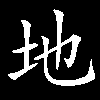

In [33]:
binary_img = cv2.bitwise_not(binary_img)
x=Image.fromarray(binary_img)
print("原始边框像素值：\n", binary_img[:5, :5])
x

/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning: Glyph 21547 (\N{CJK UNIFIED IDEOGRAPH-542B}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距
/tmp/ipykernel_1434742/909186498.py:57: UserWarning:

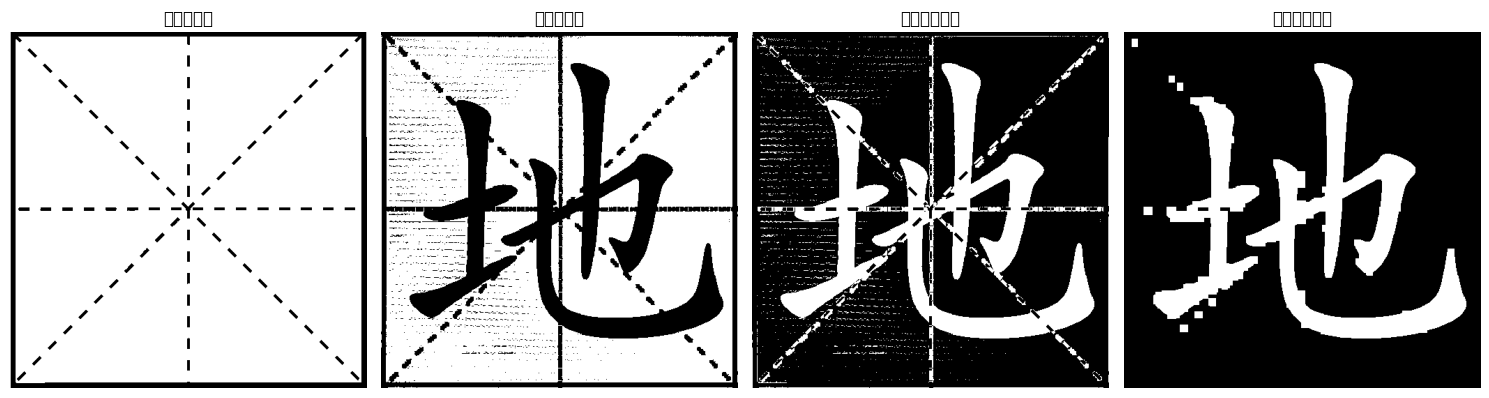

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图片（标准田字格 & 含字田字格）
template_img_path = "/home/ylyu/workspace/text_score/corrected_temp.png"  # 标准田字格（无字）
text_img_path = "/home/ylyu/workspace/text_score/corrected_img.png"  # 含字田字格

# 读取图像（灰度模式）
template_img = cv2.imread(template_img_path, cv2.IMREAD_GRAYSCALE)
text_img = cv2.imread(text_img_path, cv2.IMREAD_GRAYSCALE)
#template_img = cv2.resize(template_img, (text_img.shape[1], text_img.shape[0]))
# 确保两张图大小相同（如果不一样，需要调整）
if template_img.shape != text_img.shape:
    print(11)
    template_img = cv2.resize(template_img, (text_img.shape[1], text_img.shape[0]))

# 进行二值化处理
_, template_bin = cv2.threshold(template_img, 127, 255, cv2.THRESH_BINARY)
_, text_bin = cv2.threshold(text_img, 127, 255, cv2.THRESH_BINARY)
# template_bin = cv2.bitwise_not(template_bin)
# text_bin = cv2.bitwise_not(text_bin)
# 计算两张图的差异，去除田字格
diff_img = cv2.absdiff(text_bin, template_bin)
kernel = np.ones((3,3), np.uint8)
cleaned_img = cv2.morphologyEx(diff_img , cv2.MORPH_CLOSE, kernel, iterations=2)
kernel = np.ones((5, 5), np.uint8)
cleaned_img  = cv2.morphologyEx(cleaned_img , cv2.MORPH_OPEN, kernel,iterations=2)

# 1. 形态学操作 - 先腐蚀再膨胀（去除细小网格线）



# 绘制多个阶段的图像
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 创建1行4列的子图

# 显示原始田字格
axes[0].imshow(template_bin, cmap='gray')
axes[0].set_title("标准田字格")
axes[0].axis("off")

# 显示带田字格的汉字
axes[1].imshow(text_bin, cmap='gray')
axes[1].set_title("含字田字格")
axes[1].axis("off")

# 显示去除田字格后的差异图
axes[2].imshow(diff_img, cmap='gray')
axes[2].set_title("田字格去除后")
axes[2].axis("off")

# 显示最终去除田字格+形态学处理的图像
axes[3].imshow(cleaned_img, cmap='gray')
axes[3].set_title("最终汉字图像")
axes[3].axis("off")

plt.tight_layout()  # 自动调整子图间距
plt.show()

/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 31859 (\N{CJK UNIFIED IDEOGRAPH-7C73}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1168352/2138672114.py:59: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from curren

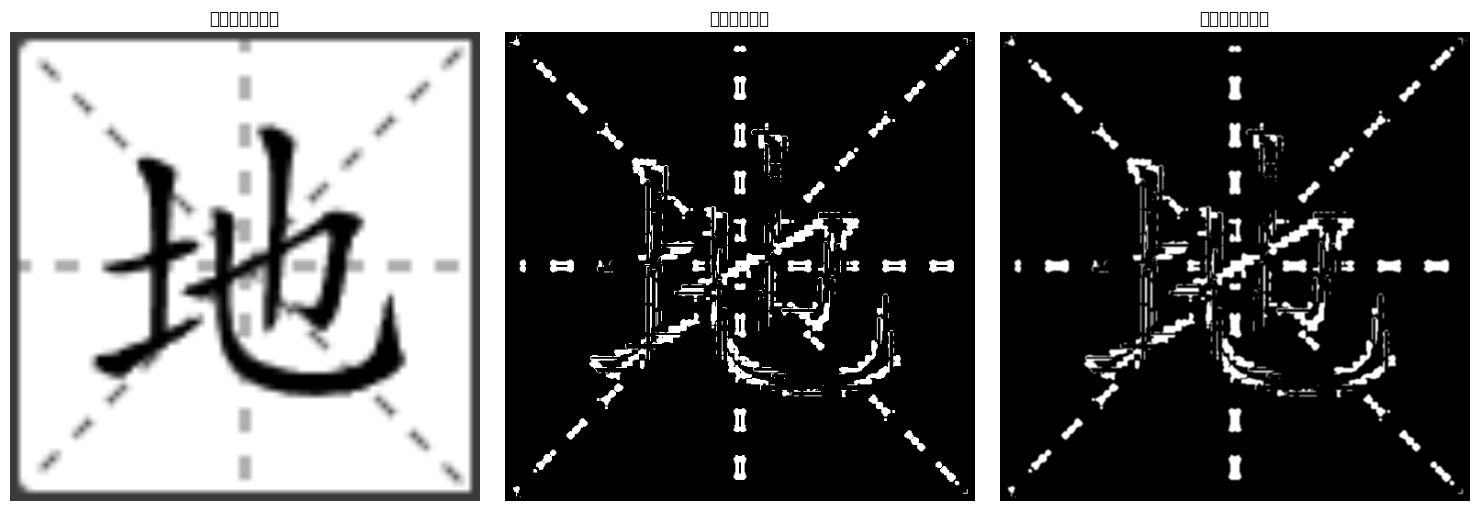

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
image_path = "/home/ylyu/workspace/text_score/corrected_img.png"  # 替换为你的图片路径
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 1️⃣ **自适应二值化**（适用于不同亮度背景）
binary_img = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

# 2️⃣ **形态学操作 - 去除米字格**
# 先尝试开运算（去除细小网格线）
kernel = np.ones((3, 3), np.uint8)
cleaned_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=1)

# 3️⃣ **去除水平和垂直网格线**
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))  # 水平
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))  # 垂直

# 提取田字格线条
horizontal_lines = cv2.morphologyEx(cleaned_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
vertical_lines = cv2.morphologyEx(cleaned_img, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

# 合并网格线
grid_lines = cv2.add(horizontal_lines, vertical_lines)

# **用减法去掉网格**
cleaned_img = cv2.subtract(cleaned_img, grid_lines)

# 4️⃣ **连通组件分析 - 保留汉字**
contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 创建空白图像
final_result = np.zeros_like(cleaned_img)

# 画出所有汉字轮廓
cv2.drawContours(final_result, contours, -1, (255), thickness=cv2.FILLED)

# 5️⃣ **平滑化处理**
final_result = cv2.GaussianBlur(final_result, (3, 3), 0)

# 🔹 **显示结果**
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("原始米字格图像")
axes[0].axis("off")

axes[1].imshow(cleaned_img, cmap='gray')
axes[1].set_title("形态学去网格")
axes[1].axis("off")

axes[2].imshow(final_result, cmap='gray')
axes[2].set_title("最终汉字去网格")
axes[2].axis("off")

plt.tight_layout()
plt.show()




In [39]:
def extract_grid_image(image, position):
    height, width = image.shape[:2]
    grid_height = height // 3
    grid_width = width // 3
    x, y = position
    start_x = x * grid_width
    start_y = y * grid_height
    end_x = start_x + grid_width
    end_y = start_y + grid_height
    end_x = min(end_x, width)
    end_y = min(end_y, height)
    grid_image = image[start_y:end_y, start_x:end_x]
    return grid_image
grid_positions = [(0, 0), (0, 1), (0, 2),
                      (1, 0), (1, 1), (1, 2),
                      (2, 0), (2, 1), (2, 2)]
handwriting_hu_moments_list = []
template_hu_moments_list = []
for position in grid_positions:
    handwriting_grid_image = extract_grid_image(thin_image1, position)
    template_grid_image = extract_grid_image(thin_image2, position)
    handwriting_hu_moments_list.append(handwriting_grid_image)
    template_hu_moments_list.append(template_grid_image)

In [44]:
x=np.nansum(np.array([0,1,None]))
x

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

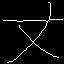

In [27]:
thin_image = cv2.ximgproc.thinning(cropped_t,thinningType=1)  # OpenCV 实现 ZS 细化
y=Image.fromarray(thin_image)
y

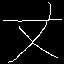

In [28]:
thin_image = cv2.ximgproc.thinning(cropped_t,thinningType=0)  # OpenCV 实现 ZS 细化
x=Image.fromarray(thin_image)
x

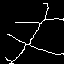

In [21]:
thin_image = cv2.ximgproc.thinning(cropped_t)  # OpenCV 实现 ZS 细化
x=Image.fromarray(thin_image)
x

In [16]:
import imageio
import torch
img = imageio.imread('/home/ylyu/workspace/text_score/data/zhang/image.png') / 255.
print(img.shape)
img = torch.tensor(img[:,:,0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
print(img.shape)

(62, 61, 3)
torch.Size([1, 1, 62, 61])


/tmp/ipykernel_3363685/3905293510.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/home/ylyu/workspace/text_score/data/zhang/image.png') / 255.


In [18]:

def template_match(img, template):
    """基于模板匹配的方法进行字符匹配"""
    result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)  # 使用归一化互相关方法
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)  # 获取最佳匹配位置
    return max_loc, max_val  # 返回匹配位置和匹配度
match_loc, match_val = template_match(cropped_t, cropped_s)
print(match_loc,match_val)

(0, 0) 0.007741409819573164


In [ ]:
result = cv2.matchTemplate(cropped_s, cropped_t, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
print(min_val, max_val, min_loc, max_loc)

0.15325266122817993 0.15325266122817993 (0, 0) (0, 0)


In [ ]:
coverage_rate=max_coverage_rate(cropped_s, cropped_t)
coverage_rate

0.0

In [9]:
hull_handwritten_norm=normalize_convex_hull(hull_s, target_size=(50, 50))
hull_template_norm=normalize_convex_hull(hull_t, target_size=(50, 50))

# 计算相似性指标
similarity = convex_hull_similarity(hull_template_norm, hull_handwritten_norm)
distance = hausdorff_distance(hull_template_norm, hull_handwritten_norm)
area_similarity, perimeter_similarity, aspect_ratio_similarity = area(hull_template_norm, hull_handwritten_norm)
print(similarity,distance,area_similarity,perimeter_similarity,aspect_ratio_similarity)

0.6724187229479572 2.0 0.6770526315789474 0.8721721484144987 0.7334183673469388


In [12]:
area_dif=np.abs(area_t-area_s)
dx = cX_target - cX_src
dy = cY_target - cY_src
offset_score = max(0, 100 - (np.sqrt(dx**2 + dy**2) *1))
# 计算面积差异的评分
area_diff_score = max(0, 100 - area_dif * 0.01)
# 计算覆盖率的评分
coverage_score = coverage_rate*2 * 100  # 假设覆盖率越高越好
# 计算凸包相似度的评分
hull_similarity_score = similarity * 100  # 相似度越高，评分越高
# 计算 Hausdorff 距离的评分
hausdorff_score = max(0, 100 - distance)  # 距离越小，评分越高
# 计算形状特征相似度的评分
shape_feature_score = (area_similarity + perimeter_similarity + aspect_ratio_similarity) / 3 * 100
print(offset_score,area_diff_score,coverage_score,hull_similarity_score,hausdorff_score,shape_feature_score)

91.45599625468247 48.67 74.50980392156863 67.24187229479573 98.0 76.08810491134615


In [13]:
final_score = (
        hull_similarity_score * 0.3 + 
        hausdorff_score * 0.2 + 
        area_diff_score * 0.2 + 
        offset_score * 0.1 + 
        coverage_score * 0.2
    )

print(f"最终评分: {final_score:.2f} / 100")

最终评分: 73.55 / 100


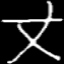

In [17]:
from PIL import Image
x=Image.fromarray(cropped_s)
y=Image.fromarray(cropped_t)
x

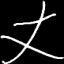

In [18]:
y


In [4]:
cX_src, cY_src = calculate_center_of_gravity(src_char_img_resized)
cX_target, cY_target = calculate_center_of_gravity(target_char_img_resized)
print(cX_src, cY_src,cX_target, cY_target)

62 62 65 70


In [17]:
import cv2
image=cv2.imread("/home/ylyu/workspace/text_score/image/test1_c.jpg")
image.shape
image1=cv2.resize(image,(768,384))
cv2.imwrite("/home/ylyu/workspace/text_score/image/test1_768.jpg",image1)
image1.shape

(384, 768, 3)

(0, 14, 80, 50)


/mnt/ylyu/conda/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20320 (\N{CJK UNIFIED IDEOGRAPH-4F60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/ylyu/conda/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


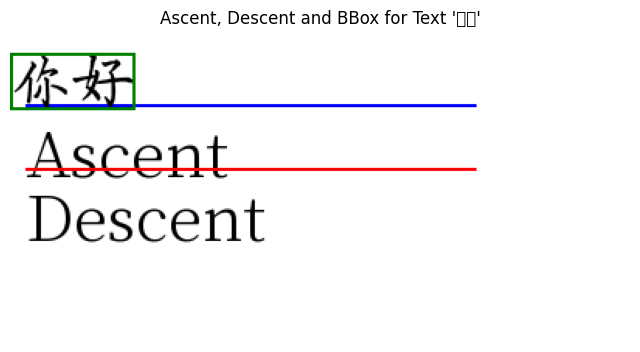

In [10]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# 设置字体和文本
font = ImageFont.truetype("/mnt/ylyu/text_data/ttf_tar/华栋正楷第三版 Regular.ttf", 40)  # 请根据需要选择字体文件
text = "你好"

# 创建一个白色背景的空白图像
image = Image.new("RGB", (400, 200), "white")
draw = ImageDraw.Draw(image)

# 使用 font.getmetrics() 获取字体的 ascent 和 descent
ascent, descent = font.getmetrics()

# 绘制字体的 ascent 和 descent 高度
draw.text((10, ascent), "Ascent", font=font, fill="black")
draw.line((10, ascent, 300, ascent), fill="blue", width=2)
#draw.text((10, ascent + 10), f"Ascent = {ascent}", font=font, fill="blue")

draw.text((10, 100 - descent), "Descent", font=font, fill="black")
draw.line((10, 100 - descent, 300, 100 - descent), fill="red", width=2)
#draw.text((10, 100 - descent - 10), f"Descent = {descent}", font=font, fill="red")

# 使用 font.getbbox(text) 获取文本的边界框
bbox = font.getbbox(text)
print(bbox)
# 绘制文本及其边界框
draw.text((0,0), text, font=font, fill="black")
draw.rectangle(bbox, outline="green", width=2)

# 保存图像
image.save("font_metrics_and_bbox.png")

# 可视化展示
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Ascent, Descent and BBox for Text '你好'")
plt.axis("off")  # 不显示坐标轴
plt.show()
